# Sentiment Analysis with RNN

This notebook demonstrates how to build, train and evaluate a sentiment analysis model using Recurrent Neural Networks (RNN).

We'll be using the IMDB movie reviews dataset for training our model to classify text as positive or negative.

## Setup and Import Libraries

In [1]:
# Install required libraries if needed
# !pip install tensorflow numpy pandas matplotlib nltk tqdm scikit-learn seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0


## Data Loading and Preprocessing

We'll load the IMDB dataset which contains 50,000 movie reviews labeled as positive or negative.

In [3]:
def load_imdb_dataset(max_features=10000, max_len=200):
    """
    Load the IMDB dataset for sentiment analysis.
    
    Args:
        max_features: Maximum number of words to consider in the vocabulary
        max_len: Maximum length of sequences
        
    Returns:
        X_train, X_val, y_train, y_val, tokenizer
    """
    # Download the IMDB dataset
    print("Loading IMDB dataset...")
    (x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.imdb.load_data(
        num_words=max_features
    )
    
    # Combine training and test data for custom split
    x_data = np.concatenate([x_train_raw, x_test_raw])
    y_data = np.concatenate([y_train, y_test])
    
    # Get word index mapping
    word_index = tf.keras.datasets.imdb.get_word_index()
    
    # Create a reverse mapping
    reverse_word_index = {i+3: word for word, i in word_index.items()}
    reverse_word_index[0] = '<PAD>'
    reverse_word_index[1] = '<START>'
    reverse_word_index[2] = '<UNK>'
    
    # Convert integer sequences back to text
    def decode_review(encoded_text):
        return ' '.join([reverse_word_index.get(i, '?') for i in encoded_text])
    
    # Convert all reviews back to text
    print("Converting reviews to text...")
    texts = [decode_review(x) for x in x_data]
    
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        texts, y_data, test_size=0.2, random_state=42
    )
    
    # Create a new tokenizer
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(X_train)
    
    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    
    # Pad sequences to ensure uniform input length
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
    
    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Training data shape: {X_train_pad.shape}")
    print(f"Validation data shape: {X_val_pad.shape}")
    
    return X_train_pad, X_val_pad, y_train, y_val, tokenizer, X_train, X_val

In [4]:
# Load and preprocess the IMDB dataset
max_features = 10000  # Size of vocabulary
max_len = 200  # Maximum length of sequences

X_train, X_val, y_train, y_val, tokenizer, raw_train_texts, raw_val_texts = load_imdb_dataset(
    max_features=max_features, 
    max_len=max_len
)

Loading IMDB dataset...
Converting reviews to text...
Vocabulary size: 9997
Training data shape: (40000, 200)
Validation data shape: (10000, 200)


## Explore the Dataset

Let's examine a few examples from the dataset.

In [5]:
# Display a few example reviews with their sentiment labels
def display_examples(texts, labels, num_examples=3):
    for i in range(num_examples):
        sentiment = "Positive" if labels[i] == 1 else "Negative"
        print(f"Example {i+1} ({sentiment}):\n{texts[i][:500]}...\n")

print("Sample reviews from the dataset:")
display_examples(raw_train_texts, y_train)

Sample reviews from the dataset:
Example 1 (Negative):
<START> rose  does anything actually happen in this episode it introduces our two leads a slow witted <UNK> idiot of a doctor and an utterly un interesting companion there's no plot to speak of childish humour mixed with some extremely bad pacing and incidental music what else is there to say really br br the end of the world  a <UNK> improvement in that we see our first outer space scenario subsequently brought down by poor contemporary humour paper thin logic very poor pacing and tired sf cl...

Example 2 (Positive):
<START> i always believed that a film that's plot is <UNK> around a virtual reality video game never sounds as though it's going to be anything special but proved i couldn't have been more wrong this film is unbelievable and whilst highly entertaining offers so much more than that from start to finish this film has you to the point where you can have so many ideas you can not make a final conclusion david <UNK> has

## Build the RNN Model

Now we'll define our RNN model for sentiment analysis.

In [6]:
def create_rnn_model(vocab_size, embedding_dim=100, input_length=200, rnn_type='lstm'):
    """
    Create a recurrent neural network model for sentiment analysis.
    
    Args:
        vocab_size: Size of the vocabulary (number of unique words)
        embedding_dim: Dimension of the embedding layer
        input_length: Maximum length of input sequences
        rnn_type: Type of RNN cell ('lstm' or 'gru')
    
    Returns:
        A compiled Keras model
    """
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    
    # RNN layer
    if rnn_type.lower() == 'lstm':
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(32)))
    elif rnn_type.lower() == 'gru':
        model.add(Bidirectional(GRU(64, return_sequences=True)))
        model.add(Bidirectional(GRU(32)))
    else:
        raise ValueError(f"Unsupported RNN type: {rnn_type}")
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
# Create and display the model architecture
embedding_dim = 100
rnn_type = 'lstm'  # Options: 'lstm' or 'gru'

model = create_rnn_model(
    vocab_size=max_features+1,  # +1 for padding token
    embedding_dim=embedding_dim,
    input_length=max_len,
    rnn_type=rnn_type
)

model.summary()

c:\Users\Ahmed\app\sentiment_analysis\sentiment_analysis\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Now we'll train our RNN model on the prepared dataset.

In [8]:
# Set up training parameters
batch_size = 64
epochs = 5  # We'll use a small number of epochs for demonstration

# Set up callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7349 - loss: 0.4956

625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 222ms/step - accuracy: 0.7351 - loss: 0.4955 - val_accuracy: 0.8811 - val_loss: 0.2797
Epoch 2/5
  9/625 ━━━━━━━━━━━━━━━━━━━━ 2:09 211ms/step - accuracy: 0.8831 - loss: 0.2656Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8961 - loss: 0.2672

625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 217ms/step - accuracy: 0.8961 - loss: 0.2671 - val_accuracy: 0.8839 - val_loss: 0.3017
Epoch 3/5
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9263 - loss: 0.2042

625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.9263 - loss: 0.2041 - val_accuracy: 0.8850 - val_loss: 0.3191
Epoch 4/5
  3/625 ━━━━━━━━━━━━━━━━━━━━ 2:37 254ms/step - accuracy: 0.9627 - loss: 0.1117Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.9441 - loss: 0.1579 - val_accuracy: 0.8769 - val_loss: 0.4177


## Evaluate the Model

Let's visualize the training progress and evaluate the model performance.

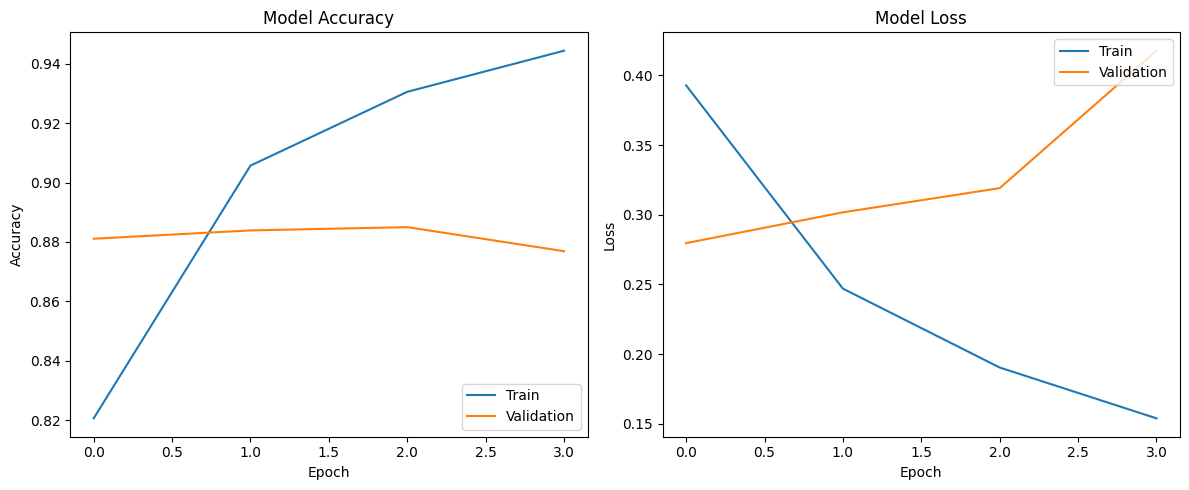

In [9]:
# Plot training & validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [10]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8804 - loss: 0.2803
Validation Loss: 0.2797
Validation Accuracy: 0.8811


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4912
           1       0.91      0.85      0.88      5088

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



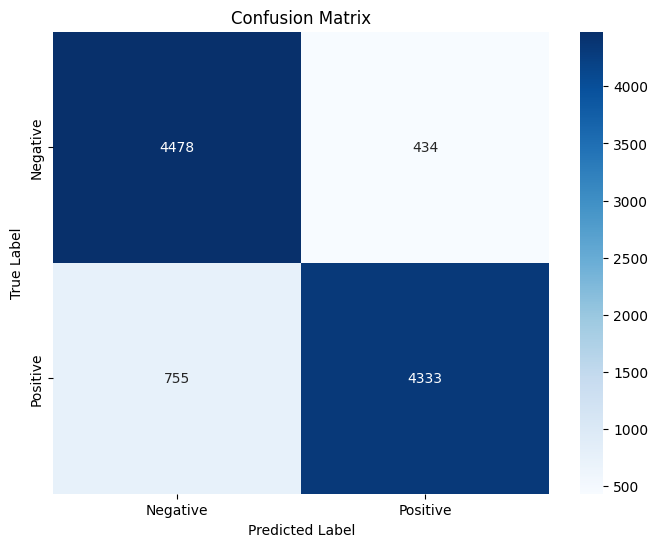

In [11]:
# Make predictions on validation data
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Test with Custom Reviews

Let's test our model with some custom reviews to see how it performs on new data.

In [12]:
def predict_sentiment(text, model, tokenizer, max_len=200):
    """
    Predict sentiment of a text
    
    Args:
        text: Text to analyze
        model: Trained sentiment analysis model
        tokenizer: Tokenizer used for training
        max_len: Maximum sequence length
    
    Returns:
        Sentiment prediction and score
    """
    # Tokenize and pad the text
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    
    # Get prediction
    prediction = model.predict(padded)[0][0]
    sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
    confidence = max(prediction, 1 - prediction) * 100
    
    return sentiment, prediction, confidence

In [13]:
# Test with custom reviews
test_reviews = [
    "This movie was absolutely terrible. I hated every minute of it.",
    "I really enjoyed this film, the acting was superb and the plot was engaging.",
    "The movie was okay, not great but not terrible either.",
    "The cinematography was beautiful, but the story didn't make any sense."
]

for i, review in enumerate(test_reviews):
    sentiment, score, confidence = predict_sentiment(review, model, tokenizer, max_len)
    print(f"Review {i+1}: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Score: {score:.4f} (0=Negative, 1=Positive)\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Review 1: This movie was absolutely terrible. I hated every minute of it.
Sentiment: Negative
Confidence: 92.59%
Score: 0.0741 (0=Negative, 1=Positive)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Review 2: I really enjoyed this film, the acting was superb and the plot was engaging.
Sentiment: Positive
Confidence: 60.87%
Score: 0.6087 (0=Negative, 1=Positive)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Review 3: The movie was okay, not great but not terrible either.
Sentiment: Negative
Confidence: 93.78%
Score: 0.0622 (0=Negative, 1=Positive)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Review 4: The cinematography was beautiful, but the story didn't make any sense.
Sentiment: Negative
Confidence: 68.19%
Score: 0.3181 (0=Negative, 1=Positive)



## Save the Model

Finally, let's save our trained model and tokenizer for later use.

In [14]:
# Save model
model.save('sentiment_model.h5')
print("Model saved as 'sentiment_model.h5'")

# Save tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved as 'tokenizer.pickle'")

Model saved as 'sentiment_model.h5'
Tokenizer saved as 'tokenizer.pickle'


## Conclusion

In this notebook, we've built a sentiment analysis model using a bidirectional RNN architecture. The model learns to classify text as positive or negative based on the language used. This is a fundamental task in natural language processing with many real-world applications.

To improve this model further, you could try:
- Using pre-trained word embeddings like GloVe or Word2Vec
- Implementing an attention mechanism
- Trying different model architectures (e.g., CNN, Transformer)
- Applying more advanced text preprocessing techniques
- Training on a larger or more diverse dataset